In [1]:
from elasticsearch import Elasticsearch

# sirve para versión previa de pandasticsearch
# ----------------------------------------------------------------------------------------------------
# from pandasticsearch import Select
# ----------------------------------------------------------------------------------------------------

from pandasticsearch.queries import Select
from pandas.io.json import json_normalize

In [2]:


# from elasticsearch import Elasticsearch
# from pandasticsearch import Select
from datetime import datetime
from dateutil import parser
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
# import psycopg2
import numpy as np
import json
from pandas.io.json import json_normalize
import pytz
import sys,os
import warnings
# warnings.filterwarnings("ignore")
import Stemmer
import re, string, unicodedata
import nltk
# import contractions
#import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer
import time

from emoji import UNICODE_EMOJI

In [3]:
import time
import pickle



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse


#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

#gráficos
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import *
import matplotlib.ticker as ticker
import seaborn


plt.style.use('seaborn-whitegrid')

In [4]:
import sklearn 
print(sklearn.__version__)

0.23.2


# Parámetros

## Kibana

In [5]:
IP_ELASTIC='10.225.245.87:9200/' 
#IP del servidor destino, tenemos localhost porque utilizamos un puente de conexión en nuestro ambiente local
PORT_ELASTIC=9200
es = Elasticsearch([IP_ELASTIC], port=PORT_ELASTIC)

## Ventana de entrenamiento

In [6]:
dias_diff = 360
fecha_mayor = time.strftime("%Y%m%d")
fecha_menor = (pd.to_datetime(fecha_mayor) - timedelta(days=dias_diff)).strftime("%d/%m/%Y")
print(fecha_mayor,fecha_menor)

20210422 27/04/2020


## Procesamiento de modelo

In [7]:
number_jobs = 8

# Funciones

In [8]:
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('spanish'):
            new_words.append(word)
    return new_words



In [9]:
def lemmatize_verbs(words):
    # ------------------------------------------------------------------------------------------------
    stemmer = Stemmer.Stemmer('spanish')
    # ------------------------------------------------------------------------------------------------
    # stemmer = SnowballStemmer('spanish')
    lemmas = stemmer.stemWords(words)
    return lemmas

In [10]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return "".join(new_words)

In [11]:
def remove_numbers(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r"^[0-9]+$", '', word)
        if new_word != '':
            new_words.append(new_word)
    return "".join(new_words)


In [12]:
def limpia_texto(text):
    """
    Recibe un string y arroja el string limpios (minúsculas, sin puntuación ni stopwords, lematizado).
    """
    try:
        assert( isinstance(text, str) or str(text)=='nan' )
        if str(text)=='nan':
            to_clean = ''
        else:
            to_clean = text
        # convierto a minusculas y transformo nulos
        pre_clean1 = to_clean.lower()
        # tokenizo
        pre_clean2 = nltk.wordpunct_tokenize(pre_clean1)
        # quito stopwords
        pre_clean3 = remove_stopwords(pre_clean2)
        # lematizo
        pre_clean4 = lemmatize_verbs(pre_clean3)
        # ya sin puntuación ni caps
        pre_clean5 = [remove_punctuation(x) for x in pre_clean4]
        clean_text = " ".join(pre_clean5)

        # construyo en df una columna con información limpia
        return clean_text
    
    except AssertionError:
        raise TypeError('El input no es string!')

In [13]:
def limpia_texto_bis(text):
    """
    Recibe un string y arroja el string limpios (minúsculas, sin puntuación ni stopwords, lematizado).
    """
    try:
        assert( isinstance(text, str) or str(text)=='nan' )
        if str(text)=='nan':
            to_clean = ''
        else:
            to_clean = text
        # convierto a minusculas y transformo nulos
        pre_clean1 = to_clean.lower()
        # tokenizo
        pre_clean2 = nltk.wordpunct_tokenize(pre_clean1)
        # quito stopwords
        pre_clean3 = remove_stopwords(pre_clean2)
        # lematizo
        pre_clean4 = [lemmatize_verbs(ll) for ll in pre_clean3]
        # ya sin puntuación ni caps
        pre_clean5 = [remove_punctuation(x) for x in pre_clean4]
        # sin #s
        pre_clean6 = [remove_numbers(x) for x in pre_clean5]
        clean_text = " ".join(pre_clean6)

        # construyo en df una columna con información limpia
        return clean_text
    
    except AssertionError:
        raise TypeError('El input no es string!')

In [14]:
def __get_data(consulta, indice, es, columnas=None):
    #Búsqueda de información  
    res = es.search(
        index=indice, #Índice(s)
        scroll='1m', #Tamaño del scroll
        request_timeout=1200, #Tiempo de espera antes de devolver timeout, segundos
        body=consulta #Query (kibana)
    )
    # print(res,"\n")
    # print(res['_scroll_id'],"\n")
    sid = res['_scroll_id'] # Identificador del scroll
    sids = [sid] # Arreglo de ids
    total_pag = res['hits']['total']['value'] # Total de documentos encontrados
    df = pd.DataFrame() # Inicialización de dataframe que se devolverá
    
    #Recorrerá set de datos encontrados, 
    #si la cantidad de registros devueltos es menor a 1000, se puede omitir el ciclo
    # print(res['hits']['hits'],"\n")
    while total_pag > 0:
        datos = res['hits']['hits'] #Set de datos
        # originalmmente, para versión previa de pandastic search, así venía
        # ----------------------------------------------------------------------------------------------------
        # df_tmp = Select.from_dict(res).to_pandas() #Pandas temporal
        # ----------------------------------------------------------------------------------------------------
        select = Select()
        select.explain_result(res)
        df_tmp = select.to_pandas() #Pandas temporal
        
        if columnas is None:
            df =  pd.concat([df, df_tmp]) #concatena pandas encontrado con columnas específicas
        else:
            df =  pd.concat([df, df_tmp[columnas]]) #concatena pandas encontrado con columnas específicas
        
        res = es.scroll(scroll_id=sid, scroll='1m') #Obtiene siguiente set de datos
        sid = res['_scroll_id'] #ID del set de datos
        sids.append(sid)
        total_pag = len(res['hits']['hits']) #Cantidad de valores encontrados
    
    es.clear_scroll(body={'scroll_id': sids}, ignore=(404)) #Borra el contexto de búsqueda
    
    return df.reindex()




In [15]:
def extract_emojis_old_function(s):
    if str(s)=='nan':
        rr = ''
    else:
        rr = ''.join(c for c in s if c in UNICODE_EMOJI)
    return rr

In [16]:
# hubo un cambio en la paquetería: modifico la función acordemente

emoji_list = [em for em in set([ss for ss in UNICODE_EMOJI['es'].keys()]+[ee for ee in UNICODE_EMOJI['en'].keys()])]

def extract_emojis(s, emojis_to_check=emoji_list):
    if str(s)=='nan':
        rr = ''
    else:
        rr = ''.join(c for c in s if c in emojis_to_check)
    return rr

# Obtengo info

In [17]:

consulta = {
    "query": {
        "bool": {
          "must": [
            {"range": {
              "date_time": {
                "gte": fecha_menor,
                #"lte": "01/08/2020", 
                "format": "dd/MM/yyyy||yyyy",
                "time_zone": "America/Mexico_City"
              }
            }}
          ]
        }
      },
      "_source":  ["NPS_GROUP","COMENTARIOS_P","COMENTARIOS_D"] 
}


In [18]:
ixs_nps = ["qualtrics_nps_cac_atencion",
"qualtrics_nps_pospago_compra",
"qualtrics_nps_pospago_renovacion",
"qualtrics_nps_prepago_recarga",]
n_ixs = len(ixs_nps)


ix_nps_uso = ["qualtrics_nps_pospago_uso",
    "qualtrics_nps_prepago_uso"]
n_ix_uso = len(ix_nps_uso)

data = []
for ii in range(n_ixs):
    ix = ixs_nps[ii]
    print(ix)
    data_ = __get_data(consulta, ix, es)
    data_["fuente"] = ix
    print(data_.shape)
    data.append(data_)
    print("\n")


qualtrics_nps_cac_atencion
(9541, 8)


qualtrics_nps_pospago_compra
(3676, 8)


qualtrics_nps_pospago_renovacion
(7943, 8)


qualtrics_nps_prepago_recarga
(4661, 8)




# Manipulo info

In [19]:
trn_tst_data = pd.concat(data).reset_index()
n_obs_total = trn_tst_data.shape[0]

# construyo y
y_feat = "nps_y"
trn_tst_data[y_feat] = np.where(trn_tst_data.NPS_GROUP==3, 1, 0)
# junto comentarios
trn_tst_data["comentarios"] = np.where(trn_tst_data.COMENTARIOS_P.isnull(), 
                                       trn_tst_data.COMENTARIOS_D, trn_tst_data.COMENTARIOS_P)
# los limpio
trn_tst_data["cleansed_text"] = [limpia_texto_bis(raw) 
                                 for raw in trn_tst_data.comentarios]

cut = .7

# divido en trn y tst
trn_tst_data["rand_num"] = np.random.uniform(0,1,n_obs_total) 
trn_data = trn_tst_data.loc[ trn_tst_data.rand_num>=cut ].copy()
tst_data = trn_tst_data.loc[ trn_tst_data.rand_num<cut ].copy()

## Balanceo

In [20]:
trn_data_ = trn_data.copy()

class_count = trn_data.groupby(y_feat)._id.count()
display(class_count)
minor_class = class_count\
[ class_count==class_count.min() ]\
.index[0]
print("Clase minoritaria:  ",minor_class)
n_obs_to_add = class_count.max()-class_count.min()
print(n_obs_to_add)
for ff in range(0,n_obs_to_add):
    fake_ix = np.random.randint(0,class_count.min())
    obs_to_add = trn_data.loc[ trn_data[y_feat]==minor_class ].iloc[fake_ix,:]
    trn_data_ = trn_data_.append(obs_to_add)
    print(trn_data_.shape)

trn_data_.groupby(y_feat)._id.count()

nps_y
0    3141
1    4655
Name: _id, dtype: int64

Clase minoritaria:   0
1514
(7797, 13)
(7798, 13)
(7799, 13)
(7800, 13)
(7801, 13)
(7802, 13)
(7803, 13)
(7804, 13)
(7805, 13)
(7806, 13)
(7807, 13)
(7808, 13)
(7809, 13)
(7810, 13)
(7811, 13)
(7812, 13)
(7813, 13)
(7814, 13)
(7815, 13)
(7816, 13)
(7817, 13)
(7818, 13)
(7819, 13)
(7820, 13)
(7821, 13)
(7822, 13)
(7823, 13)
(7824, 13)
(7825, 13)
(7826, 13)
(7827, 13)
(7828, 13)
(7829, 13)
(7830, 13)
(7831, 13)
(7832, 13)
(7833, 13)
(7834, 13)
(7835, 13)
(7836, 13)
(7837, 13)
(7838, 13)
(7839, 13)
(7840, 13)
(7841, 13)
(7842, 13)
(7843, 13)
(7844, 13)
(7845, 13)
(7846, 13)
(7847, 13)
(7848, 13)
(7849, 13)
(7850, 13)
(7851, 13)
(7852, 13)
(7853, 13)
(7854, 13)
(7855, 13)
(7856, 13)
(7857, 13)
(7858, 13)
(7859, 13)
(7860, 13)
(7861, 13)
(7862, 13)
(7863, 13)
(7864, 13)
(7865, 13)
(7866, 13)
(7867, 13)
(7868, 13)
(7869, 13)
(7870, 13)
(7871, 13)
(7872, 13)
(7873, 13)
(7874, 13)
(7875, 13)
(7876, 13)
(7877, 13)
(7878, 13)
(7879, 13)
(7880, 13)
(7881, 13)
(7882, 13)
(7883, 13)
(7884, 13)
(788

(8560, 13)
(8561, 13)
(8562, 13)
(8563, 13)
(8564, 13)
(8565, 13)
(8566, 13)
(8567, 13)
(8568, 13)
(8569, 13)
(8570, 13)
(8571, 13)
(8572, 13)
(8573, 13)
(8574, 13)
(8575, 13)
(8576, 13)
(8577, 13)
(8578, 13)
(8579, 13)
(8580, 13)
(8581, 13)
(8582, 13)
(8583, 13)
(8584, 13)
(8585, 13)
(8586, 13)
(8587, 13)
(8588, 13)
(8589, 13)
(8590, 13)
(8591, 13)
(8592, 13)
(8593, 13)
(8594, 13)
(8595, 13)
(8596, 13)
(8597, 13)
(8598, 13)
(8599, 13)
(8600, 13)
(8601, 13)
(8602, 13)
(8603, 13)
(8604, 13)
(8605, 13)
(8606, 13)
(8607, 13)
(8608, 13)
(8609, 13)
(8610, 13)
(8611, 13)
(8612, 13)
(8613, 13)
(8614, 13)
(8615, 13)
(8616, 13)
(8617, 13)
(8618, 13)
(8619, 13)
(8620, 13)
(8621, 13)
(8622, 13)
(8623, 13)
(8624, 13)
(8625, 13)
(8626, 13)
(8627, 13)
(8628, 13)
(8629, 13)
(8630, 13)
(8631, 13)
(8632, 13)
(8633, 13)
(8634, 13)
(8635, 13)
(8636, 13)
(8637, 13)
(8638, 13)
(8639, 13)
(8640, 13)
(8641, 13)
(8642, 13)
(8643, 13)
(8644, 13)
(8645, 13)
(8646, 13)
(8647, 13)
(8648, 13)
(8649, 13)
(8650, 13)

nps_y
0    4655
1    4655
Name: _id, dtype: int64

# Entreno

## Features

In [21]:
# features        
feats_words = ["pag","renov","ejecut","atencion","centr","dat",
               "pued","equip","dar","internet","servici","buen","mejor",
               "mas","client","excelent","telefon","hac","promocion","bien",
               "señal","personal","recarg","sig","sol","cobertur","plan",
               "segu","tiemp","cambi","ten","llam","red","ofrec","asi","paquet"]
n_feats_words = len(feats_words)
feats_others = ["num_monemas"]
features = feats_words+feats_others

# construyo features
for ff in range(n_feats_words):
    feat_temp = feats_words[ff]
    trn_data[feat_temp] = [1*x.__contains__(feat_temp) for x in trn_data.cleansed_text.str.split(" ")]
    
trn_data["num_monemas"] = [len(x)  if x!=[""] else 0 for x in trn_data.cleansed_text.str.split(" ")]


## Parámetros de modelo

In [22]:
rng_estimators = [xx for xx in range(100,1001,100)]
rng_depth      = [xx for xx in range(1,11,1)]
print("grid de # trees:  ", rng_estimators)
print("grid de profundidad:  ", rng_depth)


gbm_opt1 = GridSearchCV(
estimator = GradientBoostingClassifier(random_state=10000, 
    learning_rate=0.05,
    warm_start=True,
    subsample=.8),
param_grid = {'n_estimators':rng_estimators,
              'max_depth':rng_depth},
scoring='roc_auc',
n_jobs=number_jobs,
iid=False,
cv=5,
verbose=10)


grid de # trees:   [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
grid de profundidad:   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [23]:
print(trn_data.shape)
print(trn_data.groupby(y_feat)._id.count())
print("\n"*3)

gbm_opt_fit1 = gbm_opt1.fit(trn_data[features].values, trn_data[y_feat].values)


(7796, 50)
nps_y
0    3141
1    4655
Name: _id, dtype: int64




Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   18.7s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   27.1s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   32.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   40.0s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   43.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   52.1s
[Parallel(

## Almaceno

In [24]:
fecha_hoy = time.strftime("%Y%m%d")


# me quedo con los estimadores óptimos y con info del trn
gbm_lght = gbm_opt_fit1.best_estimator_


# guardo relevancia de variables
df_features = pd.DataFrame(features)
display(df_features)
df_features.to_csv("nps_cacs_{0}_features.csv".format(fecha_hoy))

# almaceno modelo en pickle
with open("gbm_mood_cacs{0}.pkl".format(fecha_hoy), "wb") as f:
    pickle.dump(gbm_lght, f)


,0
0,pag
1,renov
2,ejecut
3,atencion
4,centr
5,dat
6,pued
7,equip
8,dar
9,internet


# Evaluación de modelo 

In [25]:
# modelo cacs
# pickle
gbm = pickle.load(open("gbm_mood_cacs" +fecha_hoy+".pkl","rb"))
# variable dependiente
y_feat = "nps_y"
len_mensaje = "num_monemas"

## Creación de variables en tst y estimación

In [26]:
n_obs_tst = tst_data.shape[0]
# features        
feats_words = ["pag","renov","ejecut","atencion","centr","dat",
               "pued","equip","dar","internet","servici","buen","mejor",
               "mas","client","excelent","telefon","hac","promocion","bien",
               "señal","personal","recarg","sig","sol","cobertur","plan",
               "segu","tiemp","cambi","ten","llam","red","ofrec","asi","paquet"]
n_feats_words = len(feats_words)
feats_others = ["num_monemas"]
features = feats_words+feats_others

# construyo features
for ff in range(n_feats_words):
    feat_temp = feats_words[ff]
    tst_data[feat_temp] = [1*x.__contains__(feat_temp) for x in tst_data.cleansed_text.str.split(" ")]
    
tst_data["num_monemas"] = [len(x)  if x!=[""] else 0 for x in tst_data.cleansed_text.str.split(" ")]


#estimo
gbm = pickle.load(open("gbm_mood_cacs{0}.pkl".format(fecha_hoy),"rb"))


tst_data["prob_prom"] = gbm.predict_proba(tst_data[features])[:,1]

## Distribución de scores

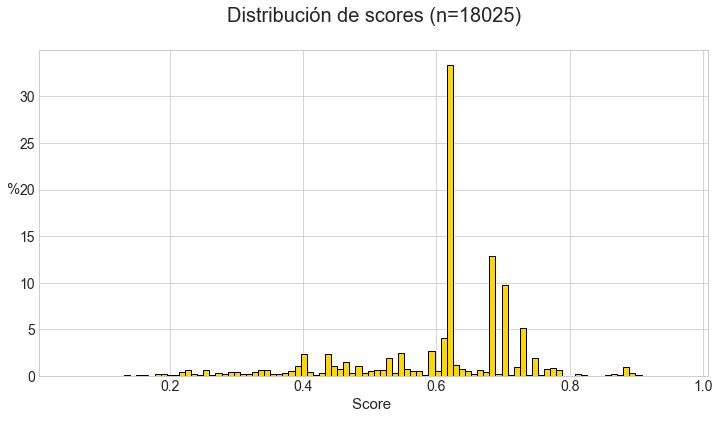

In [27]:
tst_data.prob_prom.plot(kind="hist", bins=100, figsize=(12,6), density=True,
                       color="gold", edgecolor="black")
ax = plt.gca()


ax.set_title("Distribución de scores (n={0})\n".format(n_obs_tst), size=20)
ax.set_xlabel("Score \n", size=15)
ax.set_ylabel("% \n", size=15, rotation=0)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14, rotation=0)
#quiero añadir el lift en 
ax.legend([],fontsize=15)
#ax.set_xlim(0,1)
#ax.set_ylim(0,100)



## Positivos/Negativos en distribución

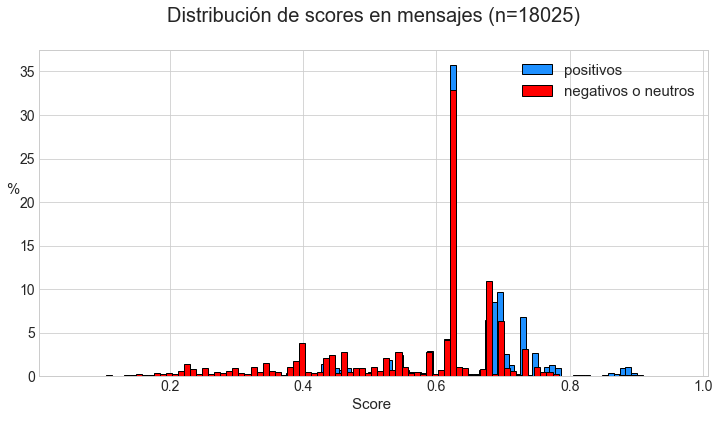

In [29]:
pp = "prob_prom"

tst_data\
.loc[ tst_data[y_feat]==1 ]\
[pp].plot(kind="hist", bins=100, figsize=(12,6), density=True,
                        color="dodgerblue", 
                 edgecolor="black",
                 label="positivos"
                )

tst_data\
.loc[ tst_data[y_feat]==0 ]\
[pp].plot(kind="hist", bins=100, figsize=(12,6), density=True,
                        color="red", 
                 edgecolor="black", label="negativos o neutros"
                )

ax = plt.gca()
ax.set_title("Distribución de scores en mensajes (n={0})\n".format(n_obs_tst), size=20)
ax.set_xlabel("Score \n", size=15)
ax.set_ylabel("% \n", size=15, rotation=0)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14, rotation=0)
ax.legend(fontsize=15)

## Positivos/Negativos por rango de score

[0.04836099 0.27700787 0.50565475 0.73430163 0.96294851]


calif_cat,negativos o neutros (1-7),positivos (9-10)
buckets,,
"(0.0474, 0.231]",78.497409,21.502591
"(0.231, 0.414]",65.757576,34.242424
"(0.414, 0.597]",48.287779,51.712221
"(0.597, 0.78]",35.384615,64.615385
"(0.78, 0.963]",11.708253,88.291747


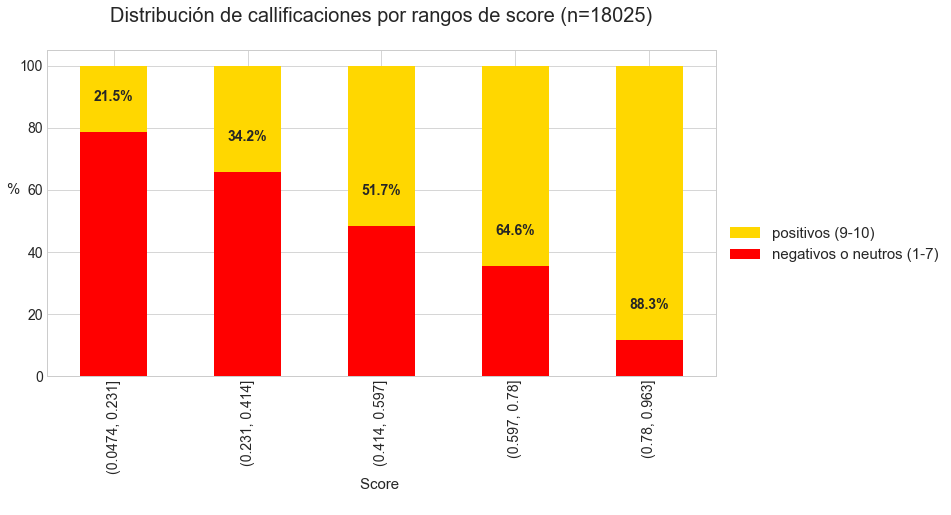

In [30]:


decs = np.linspace(tst_data[pp].min(),tst_data[pp].max(), 5)
print(decs)
tst_data["buckets"] = pd.cut(tst_data[pp], 5 )
tst_data["calif_cat"] = np.select(
    [tst_data[y_feat]==1, tst_data[y_feat]==0],
    ["positivos (9-10)","negativos o neutros (1-7)"] )

pre_toplot = tst_data\
.groupby(["buckets","calif_cat"])._id.count()\
.unstack()\
.filter(items=["negativos o neutros (1-7)","positivos (9-10)"])

pre_toplot.sum(axis=1)

toplot = 100*pre_toplot.div(pre_toplot.sum(axis=1),axis=0)

toplot.plot(kind="bar",stacked=True, figsize=(12,6), color=["red","gold"])


ax = plt.gca()
ax.set_title("Distribución de callificaciones por rangos de score (n={0})\n".format(n_obs_tst), size=20)
ax.set_xlabel("Score \n", size=15)
ax.set_ylabel("% \n", size=15, rotation=0)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)

display(toplot)
kk = toplot.shape[0]
for dd in range(kk):
    yy = toplot["negativos o neutros (1-7)"].iloc[dd]+10
    txt = str(np.round(toplot["positivos (9-10)"].iloc[dd],1))+"%"
    ax.text(dd, yy, txt, size=14, weight="bold", ha="center")



handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=15, bbox_to_anchor=(1,.5))


## Positivos/Negativos por deciles

calif_cat,negativos o neutros (1-7),positivos (9-10)
deciles,,
"(0.0474, 0.516]",61.583172,38.416828
"(0.516, 0.622]",40.225612,59.774388
"(0.622, 0.699]",34.866828,65.133172
"(0.699, 0.963]",21.362354,78.637646


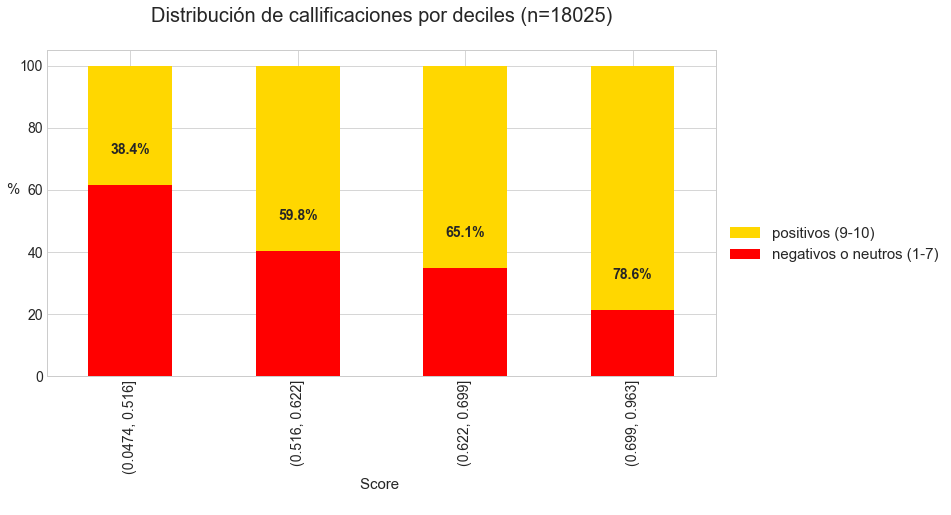

In [34]:
pp = "prob_prom"

dd = 5
decs = [.2*xx for xx in range(dd)]+[1]
tst_data["deciles"] = pd.qcut(tst_data[pp], decs,duplicates="drop" )

pre_toplot = tst_data\
.groupby(["deciles","calif_cat"])._id.count()\
.unstack()\
.filter(items=["negativos o neutros (1-7)","positivos (9-10)"])


pre_toplot.sum(axis=1)

toplot = 100*pre_toplot.div(pre_toplot.sum(axis=1),axis=0)

toplot.plot(kind="bar",stacked=True, figsize=(12,6), color=["red","gold"])


ax = plt.gca()
ax.set_title("Distribución de callificaciones por deciles (n={0})\n".format(n_obs_tst), size=20)
ax.set_xlabel("Score \n", size=15)
ax.set_ylabel("% \n", size=15, rotation=0)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)

display(toplot)
kk = toplot.shape[0]
for dd in range(kk):
    yy = toplot["negativos o neutros (1-7)"].iloc[dd]+10
    txt = str(np.round(toplot["positivos (9-10)"].iloc[dd],1))+"%"
    ax.text(dd, yy, txt, size=14, weight="bold", ha="center")


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=15, bbox_to_anchor=(1,.5))


## Curva ROC



 Corte óptimo:  0.6134334552778281


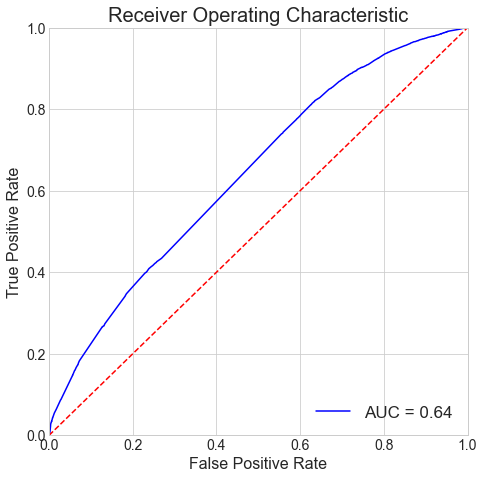

In [35]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = tst_data[pp].values
y_test = tst_data[y_feat].values
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic', size=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc,)
plt.legend(loc = 'lower right', fontsize=17)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', size=16)
plt.xlabel('False Positive Rate', size=16)

fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)

ax = plt.gca()


ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14, rotation=0)


optimal_thresh = np.min(((1-tpr)**2+fpr**2)**.5)
print("\n"*2,"Corte óptimo: ",optimal_thresh)

plt.show()



## F1 score (weighted)

,
0.00,0.441706
0.01,0.441706
0.02,0.441706
0.03,0.441706
0.04,0.441706
...,...
0.96,0.235891
0.97,0.235290
0.98,0.235290
0.99,0.235290


Umbral que maximiza score f1:  0.59


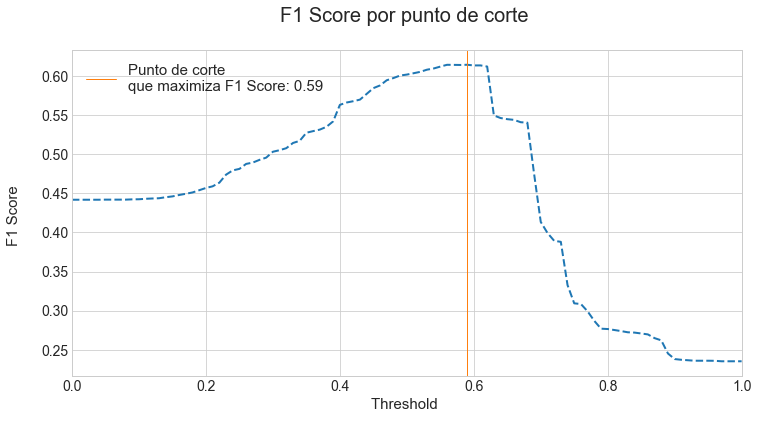

In [36]:
from sklearn.metrics import f1_score





f1_scores   = []
thresh = [tt/100 for tt in range(0,101)]
for th in thresh:
    y_true = tst_data[y_feat]
    y_pred = tst_data[pp]>=th
    f1_temp = f1_score(y_true, y_pred, average='weighted')
    f1_scores.append(f1_temp)
    
    
f1_df = pd.DataFrame(f1_scores, index=thresh,columns=
                     [""])
f1_df\
.plot(kind="line",figsize=(12,6), ls="--", lw=2,label="")

ax = plt.gca()

ax.set_title("F1 Score por punto de corte \n", size=20)
ax.set_xlabel("Threshold \n", size=15)
ax.set_ylabel("F1 Score \n", size=15)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14, rotation=0)
#quiero añadir el lift en 
ax.legend([],fontsize=15)
ax.set_xlim(0,1)


display(f1_df)

max_f1_score_th = f1_df.loc[f1_df[""]==f1_df.max().values[0]].index[0]

print("Umbral que maximiza score f1: ",max_f1_score_th)

max_ys = ax.get_ylim()
ax.plot([max_f1_score_th, max_f1_score_th],max_ys, lw=1,
        label="Punto de corte \nque maximiza F1 Score: {0}".format(np.round(max_f1_score_th,2)))
ax.set_ylim(max_ys)
ax.legend(
         fontsize=15)



tst_data["prediction"] = np.where( tst_data.prob_prom>max_f1_score_th, 1, 0 )

## Distribución de longitud de mensaje

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <BarContainer object of 50 artists> has a label of '_id' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


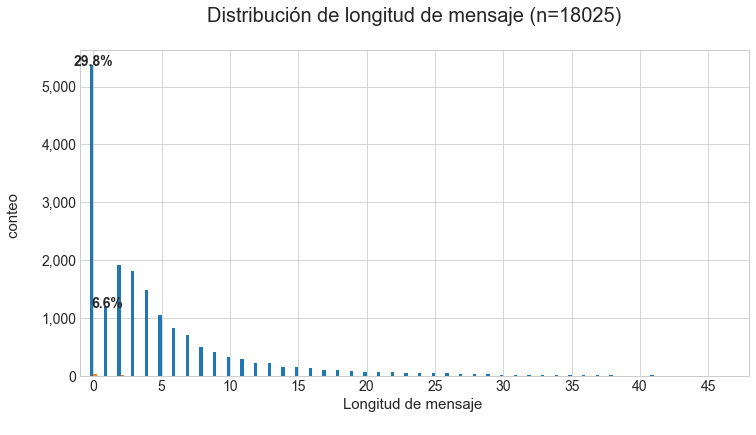

In [37]:
toplot = tst_data.groupby(len_mensaje)._id.count().to_frame()
toplot["porc"] = 100*toplot/toplot.sum()

kk = 50
toplot\
.iloc[:kk]\
.plot(kind="bar", figsize=(12,6))

ax = plt.gca()
ax.set_title("Distribución de longitud de mensaje (n={0})\n".format(n_obs_tst), size=20)
ax.set_xlabel("Longitud de mensaje \n", size=15)
ax.set_ylabel("conteo \n", size=15, rotation=90)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14, rotation=0)
ax.set_xlim(-1,48)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=15, bbox_to_anchor=(1,.5))

ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(np.round(x,0)), ',')))

ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
# ax.xaxis.set_minor_locator(ticker.MaxNLocator(40))
# ax.text(0.0, 0.1, "MaxNLocator(n=4)", fontsize=14, transform=ax.transAxes)
ax.legend([])
n_bars = toplot.shape[0]
for dd in range(int(kk/25)):
    yy = toplot["_id"].iloc[dd]
    txt = str(np.round(toplot.porc.iloc[dd],1))+"%"
    ax.text(dd, yy, txt, size=14, weight="bold", ha="center")


## Acertados por longitud de mensaje

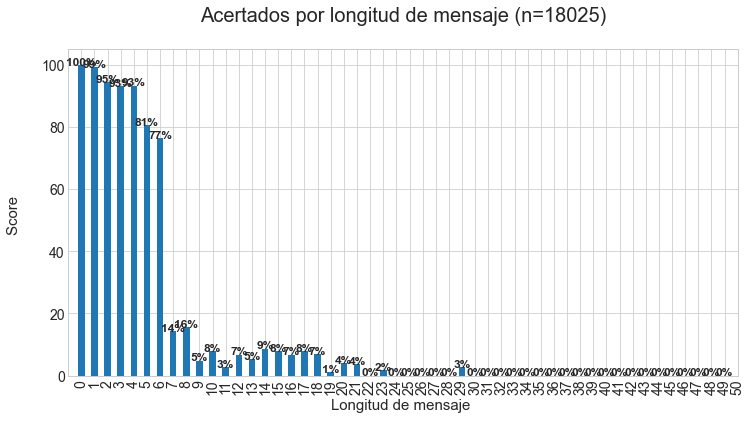

In [39]:
tst_data["correct_prediction"] = tst_data.prediction==tst_data[y_feat]
toplot = 100*tst_data.groupby(len_mensaje)["prediction"].mean()

toplot\
.plot(kind="bar", figsize=(12,6))

ax = plt.gca()
ax.set_title("Acertados por longitud de mensaje (n={0})\n".format(n_obs_tst), size=20)
ax.set_xlabel("Longitud de mensaje \n", size=15)
ax.set_ylabel("Score \n", size=15, rotation=90)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.set_xlim(-1,kk)


# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], fontsize=15, bbox_to_anchor=(1,.5))

ax.legend([])
# ax.xaxis.set_major_locator(ticker.MaxNLocator(10))


for dd in range(kk):
    yy = toplot.iloc[dd]
    txt = str(int(np.round(toplot.iloc[dd],0)))+"%"
    ax.text(dd, yy, txt, size=12, weight="bold", ha="center")


# Función de Scoreo

In [40]:
def get_prob_promotor_cacs(text, date):
    """
    Recibe un texto con comentarios limpios y arroja la probabilidad de ser promotor.
    """
    try:
        assert( isinstance(text, str) or str(text)=='nan' )
        if str(text)=='nan':
            to_clean = ''
        else:
            to_clean = text
            
        # features        
        feats_words = ["pag","renov","ejecut","atencion","centr","dat",
                       "pued","equip","dar","internet","servici","buen","mejor",
                       "mas","client","excelent","telefon","hac","promocion","bien",
                       "señal","personal","recarg","sig","sol","cobertur","plan",
                       "segu","tiemp","cambi","ten","llam","red","ofrec","asi","paquet"]
        n_feats_words = len(feats_words)
        feats_others = ["num_monemas"]
        features = feats_words+feats_others

        # creo dataframe con que se estimará (lo hago dataframe para garantizar orden de features)
        X_set = pd.DataFrame(columns=features)

        # cantidad de monemas
        X_set["num_monemas"] = [len(to_clean.split(" ")) if to_clean!=[""] else 0]

        # matriz binaria sobre la presencia de palabras
        for ff in range(n_feats_words):
            feat_temp = feats_words[ff]
            X_set[feat_temp] = 1*to_clean.split(" ").__contains__(feat_temp)

        #estimo
        gbm = pickle.load(open("gbm_mood_cacs{0}.pkl".format(date),"rb"))
        prob_promotor = gbm.predict_proba(X_set[features])[:,1]

        return prob_promotor[0]
    
    except AssertionError:
        raise TypeError('El input no es string!')

In [41]:
def get_prob_promotor_whatsapp(text_comentarios, text_case):
    """
    Recibe un texto con comentarios limpios y arroja la probabilidad de ser promotor.
    """
    try:
        assert( isinstance(text_comentarios, str) or str(text_comentarios)=='nan')
        assert( isinstance(text_case, str) or str(text_case)=='nan')
        if str(text_comentarios)=='nan' and str(text_case)=='nan':
            to_clean1 = ''
            to_clean2 = ''
        elif str(text_comentarios)=='nan':
            to_clean1 = ''
        elif str(text_case)=='nan':
            to_clean2 = ''
        else:
            to_clean1 = text_comentarios
            to_clean2 = text_case
            
        # features        
        feats_words = ["bandera_señorit","bandera_ayud","bandera_asesor","bandera_lent",
                       "bandera_mejor","bandera_exelent","bandera_hor","bandera_bien",
                       "bandera_gust","bandera_rap","bandera_telefon","bandera_tiemp",
                       "bandera_atencion","bandera_llam","bandera_sol","bandera_si",
                       "bandera_servici","bandera_graci","bandera_atend","bandera_brind",
                       "bandera_contest","bandera_atent","bandera_excelent","bandera_tard",
                       "bandera_amabl","bandera_solucion","bandera_vez","bandera_buen",
                       "bandera_ningun","bandera_problem","bandera_resolv","bandera_person",
                       "bandera_respond","bandera_much","bandera_ejecut","bandera_esper","bandera_robot"]
        n_feats_words = len(feats_words)
        feats_others =  ["len_mensaje",
                         "bandera_emoji","bandera_emoji_bad","bandera_emoji_good","bandera_signo_exclamacion",
                         "bandera_groserias",
                         "len_mensaje_case","bandera_emoji_case","bandera_emoji_bad_case","bandera_emoji_good_case",
                         "bandera_signo_exclamacion_case","bandera_groserias_case"]
        features = feats_words+feats_others

        # creo dataframe con que se estimará (lo hago dataframe para garantizar orden de features)
        X_set = pd.DataFrame(columns=features)
        
        groserias = ["pinch", "pendej", "nefast", "idiot", "estupid", "estúpid","put","ching",
                     "mierd", "maldit","caraj", "inept","imbéc", "imbec", "basur", "porqueria"]
        emoji_bad = ["😒","😔","😭","😡","😩",
                     "🥺","😕","🙄",
                     "😑","🤐"]+[":\(", "\):", ":'\("]
        emoji_good = [ "😘","🤩","😊","🙂","☺","💗","✌","👍","😉","👌","😃	"]+[":\)", "\(:"]

        # otras feats de comentarios
        X_set["len_mensaje"] = [len(to_clean1.split(" ")) if to_clean1!=[""] else 0]
        X_set["bandera_signo_exclamacion"] = 1*to_clean1.__contains__('|'.join(["!","¡"]))
        X_set["bandera_groserias"] = 1*to_clean1.__contains__('|'.join(groserias))
        X_set["bandera_emoji_bad"] = 1*to_clean1.__contains__("|".join(emoji_bad))
        X_set["bandera_emoji_good"] = 1*to_clean1.__contains__("|".join(emoji_good))
        X_set["bandera_emoji"] = 1*extract_emojis(to_clean1)!=""
        # otras feats de case
        X_set["len_mensaje_case"] = [len(to_clean2.split(" ")) if to_clean2!=[""] else 0]
        X_set["bandera_signo_exclamacion_case"] = 1*to_clean2.__contains__('|'.join(["!","¡"]))
        X_set["bandera_groserias_case"] = 1*to_clean2.__contains__('|'.join(groserias))
        X_set["bandera_emoji_bad_case"] = 1*to_clean2.__contains__("|".join(emoji_bad))
        X_set["bandera_emoji_good_case"] = 1*to_clean2.__contains__("|".join(emoji_good))
        X_set["bandera_emoji_case"] = 1*extract_emojis(to_clean2)!=""
        # matriz binaria sobre la presencia de palabras
        for ff in range(n_feats_words):
            feat_temp = feats_words[ff]
            X_set[feat_temp] = 1*to_clean1.split(" ").__contains__(feat_temp.replace("bandera_",""))

        #estimo
        gbm = pickle.load(open("gbm_mood_whatsapp_calib1.pkl","rb"))
        prob_promotor = gbm.predict_proba(X_set[features])[:,1]

        return prob_promotor[0]
    
    except AssertionError:
        raise TypeError('El input no es string!')

In [42]:
def get_prob_promotor_whatsapp_v2(text_comentarios, text_case):
    """
    Recibe un texto con comentarios limpios y arroja la probabilidad de ser promotor.
    """
    try:
        assert( isinstance(text_comentarios, str) or str(text_comentarios)=='nan')
        assert( isinstance(text_case, str) or str(text_case)=='nan')
        if str(text_comentarios)=='nan' and str(text_case)=='nan':
            to_clean1 = ''
            to_clean2 = ''
        elif str(text_comentarios)=='nan':
            to_clean1 = ''
        elif str(text_case)=='nan':
            to_clean2 = ''
        else:
            to_clean1 = text_comentarios
            to_clean2 = text_case
            
        # features        
        feats_words = ['bandera_respuest',
                       'bandera_dud',
                       'bandera_ayud',
                       'bandera_pued',
                       'bandera_exelent',
                       'bandera_contest',
                       'bandera_telefon',
                       'bandera_si',
                       'bandera_atent',
                       'bandera_amabl',
                       'bandera_llam',
                       'bandera_buen',
                       'bandera_person',
                       'bandera_lent',
                       'bandera_bien',
                       'bandera_servici',
                       'bandera_rap',
                       'bandera_solucion',
                       'bandera_ejecut',
                       'bandera_asesor',
                       'bandera_eficient',
                       'bandera_mejor',
                       'bandera_hor',
                       'bandera_problem',
                       'bandera_excelent',
                       'bandera_tiemp',
                       'bandera_graci',
                       'bandera_resolv',
                       'bandera_ningun',
                       'bandera_respond',
                       'bandera_sol',
                       'bandera_tard',
                       'bandera_atencion',
                       'bandera_deb',
                       'bandera_atend',
                       'bandera_much']


        n_feats_words = len(feats_words)
        feats_words_case = ["bandera_app_case",
                            "bandera_pag_case",
                            "bandera_dia_case",
                            "bandera_favor_case",
                            "bandera_ayud_case",
                            "bandera_pued_case",
                            "bandera_telefon_case",
                            "bandera_cambi_case",
                            "bandera_veng_case",
                            "bandera_dias_case",
                            "bandera_podr_case",
                            "bandera_buen_case",
                            "bandera_quis_case",
                            "bandera_noch_case",
                            "bandera_sald_case",
                            "bandera_cancel_case",
                            "bandera_servici_case",
                            "bandera_problem_case",
                            "bandera_graci_case",
                            "bandera_hol_case",
                            "bandera_tard_case",
                            "bandera_plan_case",
                            "bandera_movist_case",]
        n_feats_words_case = len(feats_words_case)
        # features words 
        feats_others =  ["len_mensaje",
            "bandera_emoji","bandera_emoji_bad","bandera_emoji_good","bandera_signo_exclamacion","bandera_groserias",
#             case
            "len_mensaje_case",
            "bandera_emoji_case","bandera_emoji_bad_case","bandera_emoji_good_case",
            "bandera_signo_exclamacion_case","bandera_groserias_case",
            "bandera_comentario_vacio"]
        features =  feats_others+ [ww for ww in feats_words] + [cc for cc in feats_words_case]

        # creo dataframe con que se estimará (lo hago dataframe para garantizar orden de features)
        X_set = pd.DataFrame(columns=features)
        
        groserias = ["pinch", "pendej", "nefast", "idiot", "estupid", "estúpid","put","ching",
                     "mierd", "maldit","caraj", "inept","imbéc", "imbec", "basur", "porqueria"]
        emoji_bad = ["😒","😔","😭","😡","😩",
                     "🥺","😕","🙄",
                     "😑","🤐"]+[":\(", "\):", ":'\("]
        emoji_good = [ "😘","🤩","😊","🙂","☺","💗","✌","👍","😉","👌","😃	"]+[":\)", "\(:"]

        # otras feats de comentarios
        X_set["len_mensaje"] = [len(to_clean1.split(" ")) if to_clean1!=[""] else 0]
        X_set["bandera_signo_exclamacion"] = 1*to_clean1.__contains__('|'.join(["!","¡"]))
        X_set["bandera_groserias"] = 1*to_clean1.__contains__('|'.join(groserias))
        X_set["bandera_emoji_bad"] = 1*to_clean1.__contains__("|".join(emoji_bad))
        X_set["bandera_emoji_good"] = 1*to_clean1.__contains__("|".join(emoji_good))
        X_set["bandera_emoji"] = 1*extract_emojis(to_clean1)!=""
        # otras feats de case
        X_set["len_mensaje_case"] = [len(to_clean2.split(" ")) if to_clean2!=[""] else 0]
        X_set["bandera_signo_exclamacion_case"] = 1*to_clean2.__contains__('|'.join(["!","¡"]))
        X_set["bandera_groserias_case"] = 1*to_clean2.__contains__('|'.join(groserias))
        X_set["bandera_emoji_bad_case"] = 1*to_clean2.__contains__("|".join(emoji_bad))
        X_set["bandera_emoji_good_case"] = 1*to_clean2.__contains__("|".join(emoji_good))
        X_set["bandera_emoji_case"] = 1*extract_emojis(to_clean2)!=""
        X_set["bandera_comentario_vacio"] = 1*to_clean2==""
        # matriz binaria sobre la presencia de palabras
        for ff in range(n_feats_words):
            feat_temp = feats_words[ff]
            X_set[feat_temp] = 1*to_clean1.split(" ").__contains__(feat_temp.replace("bandera_",""))
        
        for ff in range(n_feats_words_case):
            feat_temp = feats_words_case[ff]
            X_set[feat_temp] = 1*to_clean2.split(" ").__contains__(feat_temp.replace("bandera_","").replace("_case",""))

        #estimo
        gbm = pickle.load(open("gbm_mood_whatsapp20210415.pkl","rb"))
        prob_promotor = gbm.predict_proba(X_set[features])[:,1]

        return prob_promotor[0]
    
    except AssertionError:
        raise TypeError('El input no es string!')

In [43]:
get_prob_promotor_whatsapp_v2(limpia_texto_bis("resolvió"),limpia_texto_bis("quiero cambiar de plan"))

0.4774850903516705

In [46]:
get_prob_promotor_whatsapp(limpia_texto_bis("resolvió"),limpia_texto_bis("quiero cambiar de plan"))

0.6626792674895196